## Analog Encryption Demo

In [20]:
import math
import secrets
import time

from typing import Callable, Any

import numpy as np
import numpy.fft
import matplotlib.pyplot as plt
%matplotlib inline

import sounddevice as sd

import utils
import permutations

In [21]:
def complex_from_polar(magnitude: np.ndarray, angle: np.ndarray) -> np.ndarray:
    """create a complex array from magnitude and angle"""
    return magnitude * np.exp(1j * angle)

### Loading the audio sample

In [22]:
fsps = 8000 # audio sample frequency

In [23]:
# read PCM audio samples from file (format: int16 little endian)
samples = utils.read_raw_audio("sample_8000hz.raw")

In [24]:
# listen to the audio sample
sd.play(samples, samplerate=fsps, blocking=True)

Text(0.5, 1.0, '"Four score and seven years ago ..."')

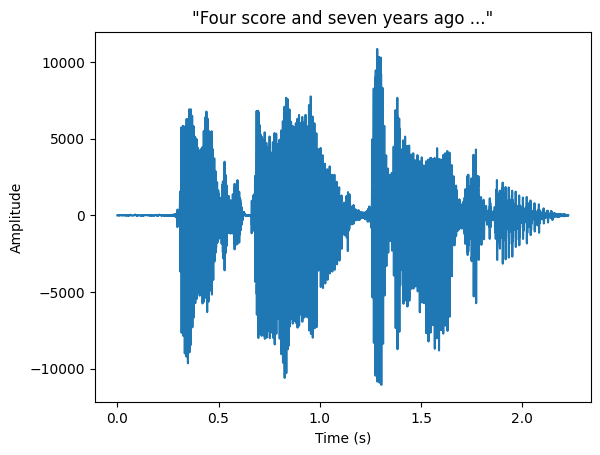

In [25]:
# visualize the audio sample
t = np.arange(len(samples)) / fsps
plt.figure()
plt.plot(t, samples)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("\"Four score and seven years ago ...\"")

We will divide the audio signal into 256-samples block (32ms each at 8000Hz). For each block, we will take the Discrete Fourier Transform, and permute the frequency components using a key.

We only care about frequency components in the audioable frequency range, which is roughly from 300Hz to 3400Hz.

The FFT coefficients for real signal has conjugate symmetry. So, we must maintain this property when performing permutation to ensure the signal after transform is real.

Based on the above constraint, there are 99 frequency components we can work with

In [26]:
# size of each frame
block_size = 256

freq = np.linspace(-block_size / 2, block_size / 2 - 1, block_size) / block_size * fsps
usable_freq = np.logical_and(np.abs(freq) > 300, np.abs(freq) < 3400)
permutation_size = int(np.sum(usable_freq) / 2)
print(permutation_size)

99


In [27]:
usable_freq_shifted = np.fft.ifftshift(usable_freq)
# masks to perform permutations
permutation_mask = np.fft.ifftshift(np.logical_and(usable_freq, freq > 0))
reverse_permutation_mask = np.fft.ifftshift(np.logical_and(usable_freq, freq < 0))

Text(0.5, 0, '256 DFT Coefficient')

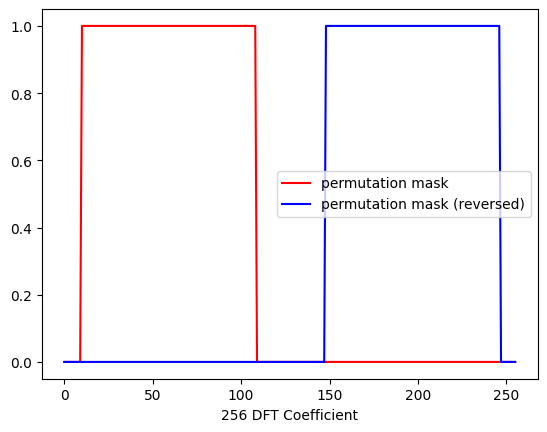

In [29]:
plt.figure()
plt.plot(permutation_mask, 'r', label="permutation mask")
plt.plot(reverse_permutation_mask, 'b', label="permutation mask (reversed)")
plt.legend()
plt.xlabel("256 DFT Coefficient")

Here is a helper function to process the audio signal. It takes a transformation function as argument and call it for each 256-sample block

In [30]:
def transform_audio(samples: np.ndarray, transform_fn: Callable[[np.ndarray], np.ndarray]) -> np.ndarray:
    idx = 0
    res = np.zeros(((len(samples) // block_size) * block_size, ), dtype='int16')
    while True:
        data = samples[idx:idx+block_size].astype("float")
        if len(data) < block_size:
            break
        res[idx:idx+block_size] = transform_fn(data).astype('int16')
        idx += block_size
    return res

Let's try permuting the FFT coefficients (feel free to try different permutation strategy)

In [31]:
def permute_direct(block: np.ndarray, p: list[int]) -> np.ndarray:
    spectrum = np.fft.fft(block)

    # permute frequency
    spectrum[permutation_mask] = spectrum[permutation_mask][p]
    spectrum[reverse_permutation_mask] = spectrum[reverse_permutation_mask][::-1][p][::-1]

    return np.real(np.fft.ifft(spectrum))

In [32]:
def permute_angle(block: np.ndarray, p: list[int]) -> np.ndarray:
    spectrum = np.fft.fft(block)

    angles = np.angle(spectrum[permutation_mask])[p]
    spectrum[permutation_mask] = complex_from_polar(np.absolute(spectrum[permutation_mask]), angles)
    angles = np.angle(spectrum[reverse_permutation_mask][::-1])[p][::-1]
    spectrum[reverse_permutation_mask] = complex_from_polar(np.absolute(spectrum[reverse_permutation_mask]), angles)

    return np.real(np.fft.ifft(spectrum))

In [33]:
def permute_magnitude(block: np.ndarray, p: list[int]) -> np.ndarray:
    spectrum = np.fft.fft(block)

    mag = np.absolute(spectrum[permutation_mask])[p]
    spectrum[permutation_mask] = complex_from_polar(mag, np.angle(spectrum[permutation_mask]))
    mag = np.absolute(spectrum[reverse_permutation_mask][::-1])[p][::-1]
    spectrum[reverse_permutation_mask] = complex_from_polar(mag, np.angle(spectrum[reverse_permutation_mask]))

    return np.real(np.fft.ifft(spectrum))

In [34]:
# generate a random permutation (and its inverse)
enc_p = permutations.random_permutation(secrets.token_bytes, permutation_size)
dec_p = permutations.inverse(enc_p)

In [35]:
result = transform_audio(samples, lambda s: permute_direct(s, enc_p))
# result = transform_audio(samples, lambda s: permute_angle(s, enc_p)) # this does not work at all
# result = transform_audio(samples, lambda s: permute_magnitude(s, enc_p))

Permutation does not change the general shape of the waveform

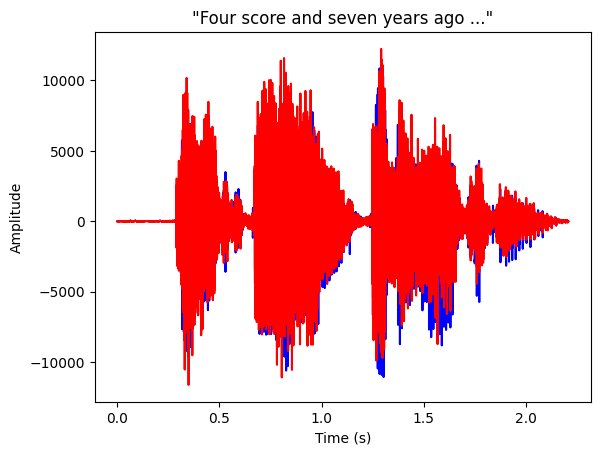

In [36]:
t = np.arange(len(result)) / fsps
plt.figure()
plt.plot(t, samples[:len(result)], "b", label="original")
plt.plot(t, result, "r", label="transformed")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("\"Four score and seven years ago ...\"")
plt.show()

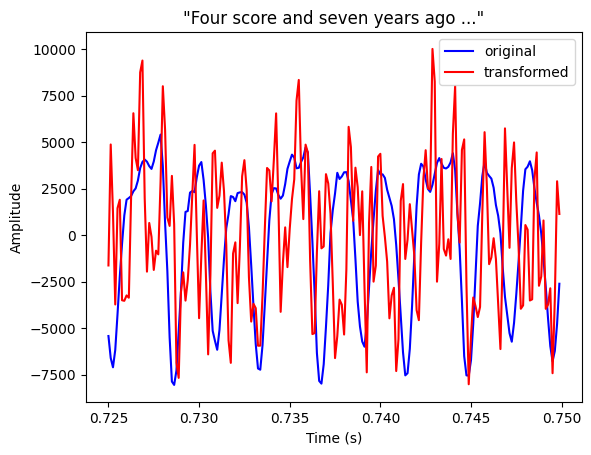

In [37]:
t = np.arange(len(result)) / fsps
plt.figure()
plt.plot(t[5800:6000], samples[5800:6000], "b", label="original")
plt.plot(t[5800:6000], result[5800:6000], "r", label="transformed")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("\"Four score and seven years ago ...\"")
plt.show()

The "encrypted" signal is still somewhat recognizable

In [38]:
sd.play(result, samplerate=fsps, blocking=True)

In [19]:
# save the encrypted output
utils.write_raw_audio('sample_enc_8000hz.raw', result)

17664

Let's try decrypting it (just to show it actually works)

In [39]:
decrypted = transform_audio(result, lambda s: permute_direct(s, dec_p))
# decrypted = transform_audio(result, lambda s: permute_angle(s, dec_p))
# decrypted = transform_audio(result, lambda s: permute_magnitude(s, dec_p))

In [40]:
sd.play(decrypted, samplerate=fsps, blocking=True)

## What's wrong with this approach?

1. The audio signal (especially those contains human voice) has a lot of redundency. This means that even if the signal has been modified to an certain extent, a human are still able to understand the meaning of the audio.
2. Permutation is a linear process, which makes it a not so great for encryption.

## Why is direct encryption on analog signal (in general) a bad idea?

A good encryption scheme usually involves both *confusion* (a process that obsecure the local corelation such as substitution) and *diffusion* (a process that spread the local statistics to a wider area) according to Shannon. In practice, confusion is commonly implemented as substituion, while diffusion is usually implemented as permutation. These processes are usually applied iteratively for many rounds, and the resulted cipher text are indistinguishable from randomly generated data.

Analog signals are "fuzzy" as their precision depends on measurement and the presense of noise. Because confusion and diffusion processes are applied for many rounds, any inaccuracy as a result of measurement or noise will get spread out to a wide area. In practice, a single bit of difference in plaintext will result in completely different ciphertext and vice versa. This makes direct encryption of analog signal difficult if not impossible.

In practice, while it's possible to implement diffusion process in analog signal (like what we did), it's generally very difficult to implement confusion due to it's nonlinear property. A diffusion-only cipher is weak and usually subject to many form of known attacks.
 

## How to improve it?

Convert the signal into a digital representation and encrypt it using well-known digital encryption methods (such as AES).